# fMRI Signal Statistics Analysis

This notebook analyzes the signal magnitudes (Mean) and variabilities (Standard Deviation) of fMRI data across subjects, sites, and groups (OCD vs Healthy Controls) for the ENIGMA-OCD dataset.

These two metrics correspond to the parameters used in Z-scaling normalization: $z = (x - \mu) / \sigma$.

**Objectives:**
1. Calculate Mean and Standard Deviation for each subject.
2. Compare these metrics across study sites (Scanner effects), color-coded by Scanner Manufacturer.
3. Compare these metrics across OCD and HC groups (Biological vs Confound effects).
4. Detailed breakdown by Site and Group.

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ttest_ind

In [31]:
# --- Configuration ---
PHENOTYPE_PATH = "/pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_QC_final_subject_list.csv"
SCANNER_PARAMS_PATH = "/pscratch/sd/p/pakmasha/enigma_quantum/metadata/ENIGMA_OCD_parameters.csv"
FMRI_DATA_ROOT = "/pscratch/sd/p/pakmasha/enigma_quantum_data"  # Updated path
TARGET_COLUMN = "OCD"  # 1 for OCD, 0 for HC (assumed)
ID_COLUMN = "Unique_ID"

# Set Plotting Style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Data and Calculate Statistics

In [32]:
# Load Phenotypes
df = pd.read_csv(PHENOTYPE_PATH)
print(f"Loaded phenotype data: {df.shape}")

# Load Scanner Parameters
scanner_df = pd.read_csv(SCANNER_PARAMS_PATH)
print(f"Loaded scanner params: {scanner_df.shape}")
# Map Site to Scanner
site_to_scanner = dict(zip(scanner_df['Site'], scanner_df['Scanner']))
site_to_model = dict(zip(scanner_df['Site'], scanner_df['Model_unified']))

# Filter for necessary columns
if TARGET_COLUMN not in df.columns:
    print(f"Warning: Target column '{TARGET_COLUMN}' not found via exact match. Checking columns...")
    print(df.columns.tolist())
    
df_filtered = df[[ID_COLUMN, TARGET_COLUMN]].copy()
df_filtered = df_filtered.dropna()

# Add Site Column (Assuming format {Site}_{ID})
def extract_site(unique_id):
    parts = str(unique_id).split('_')
    if len(parts) > 1:
        return parts[0]
    else:
        return "Unknown"

df_filtered['Site'] = df_filtered[ID_COLUMN].apply(extract_site)

# Add Scanner Column
df_filtered['Scanner'] = df_filtered['Site'].map(site_to_scanner)
df_filtered['Scanner'] = df_filtered['Scanner'].fillna("Unknown")

# Add Scanner Model Column
df_filtered['ScannerModel'] = df_filtered['Site'].map(site_to_model)
df_filtered['ScannerModel'] = df_filtered['ScannerModel'].fillna("Unknown")

print(f"Subjects after filtering NaNs: {len(df_filtered)}")
print(f"Unique Sites found: {df_filtered['Site'].nunique()}")
print(f"Scanner Manufacturers: {df_filtered['Scanner'].unique()}")

Loaded phenotype data: (2095, 21)
Loaded scanner params: (29, 6)
Subjects after filtering NaNs: 2095
Unique Sites found: 29
Scanner Manufacturers: ['GE' 'Siemens' 'Philips']


In [33]:
# Iterate and Calculate Signal Stats
results = []

for index, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Processing Subjects"):
    sub_id = row[ID_COLUMN]
    group_label = row[TARGET_COLUMN]
    site = row['Site']
    scanner = row['Scanner']
    scanner_model = row['ScannerModel']
    
    # Construct fMRI Path
    fmri_path = os.path.join(FMRI_DATA_ROOT, str(sub_id), f"{sub_id}.npy")
    
    if not os.path.exists(fmri_path):
        continue
        
    try:
        # Load .npy file
        data = np.load(fmri_path)
        
        # Calculate Metrics
        mean_signal = np.mean(data)
        std_signal = np.std(data)
        
        results.append({
            'Unique_ID': sub_id,
            'Site': site,
            'Scanner': scanner,
            'ScannerModel': scanner_model,
            'Group': 'OCD' if group_label == 1 else 'HC',
            'Mean_Signal': mean_signal,
            'Std_Signal': std_signal
        })
        
    except Exception as e:
        print(f"Error processing {sub_id}: {e}")

stats_df = pd.DataFrame(results)
print(f"Successfully processed {len(stats_df)} subjects.")

Processing Subjects: 100%|██████████| 2095/2095 [00:03<00:00, 554.58it/s]

Successfully processed 1706 subjects.


## 2. Mean Magnitude Analysis (Shift in Z-score)

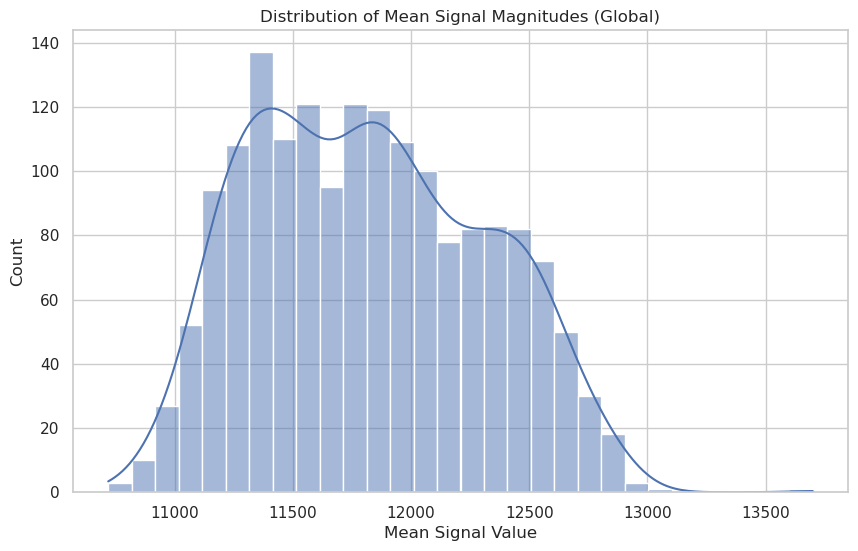

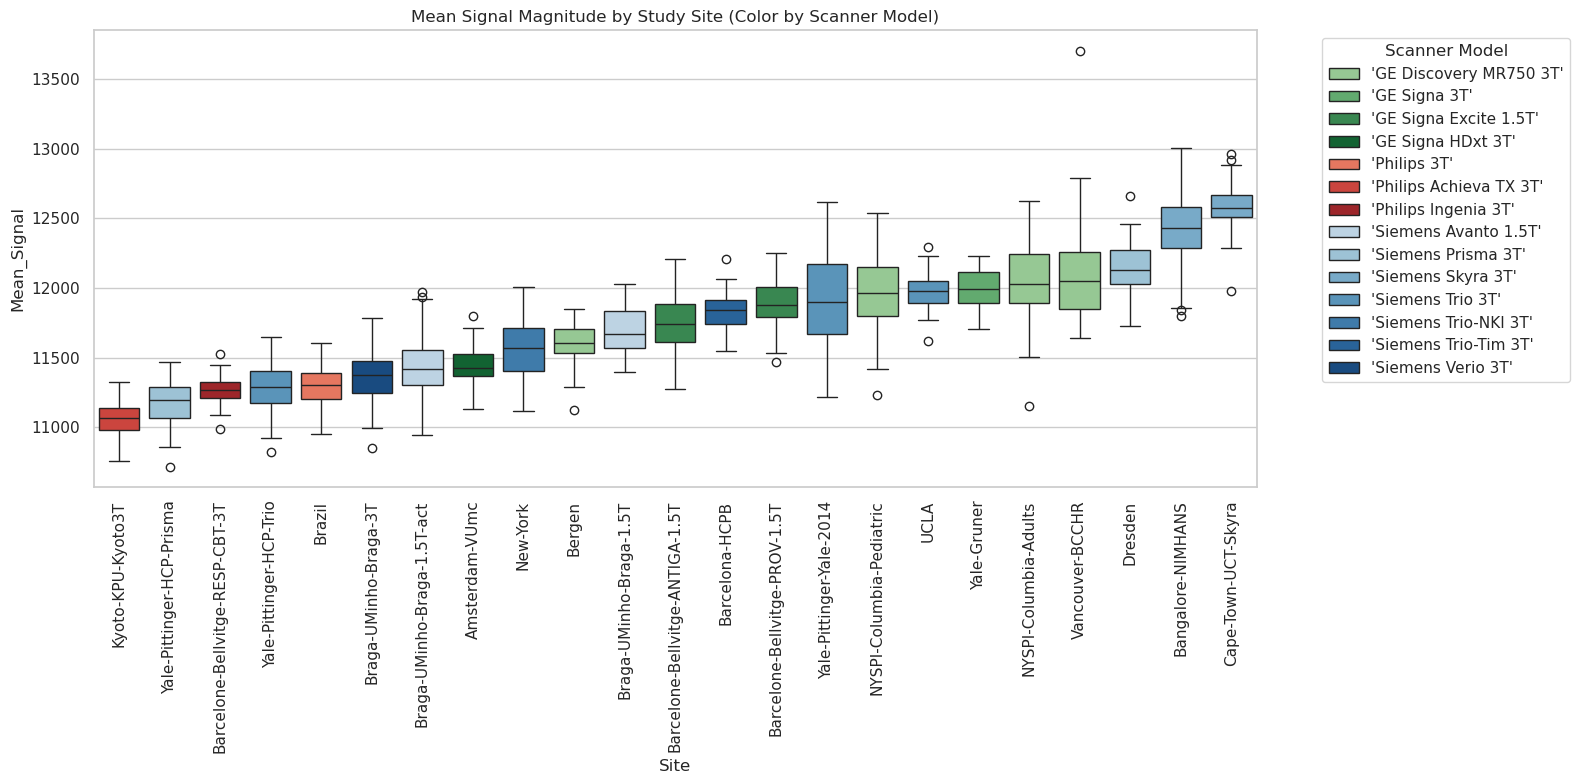

/tmp/ipykernel_2293218/2021900158.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Mean_Signal', data=stats_df, palette="Set2")


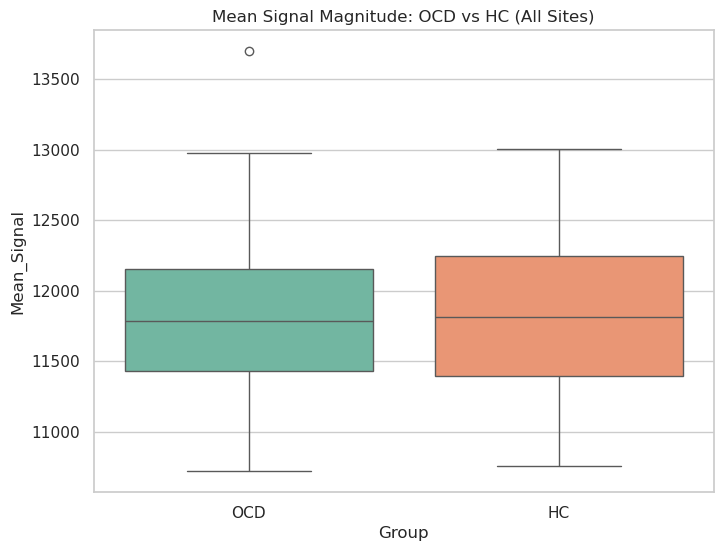

In [34]:
# Define Color Palette for Models
unique_models = sorted(stats_df['ScannerModel'].unique())
siemens_models = [m for m in unique_models if 'Siemens' in m]
ge_models = [m for m in unique_models if 'GE' in m]
philips_models = [m for m in unique_models if 'Philips' in m]
others = [m for m in unique_models if m not in siemens_models + ge_models + philips_models]

# Using seaborn palettes
siemens_pal = sns.color_palette("Blues", n_colors=len(siemens_models)+2)[2:]
ge_pal = sns.color_palette("Greens", n_colors=len(ge_models)+2)[2:]
philips_pal = sns.color_palette("Reds", n_colors=len(philips_models)+2)[2:]

model_colors = {}
for i, m in enumerate(siemens_models): model_colors[m] = siemens_pal[i]
for i, m in enumerate(ge_models): model_colors[m] = ge_pal[i]
for i, m in enumerate(philips_models): model_colors[m] = philips_pal[i]
for m in others: model_colors[m] = 'gray'

# 1) Global Distribution
plt.figure(figsize=(10, 6))
sns.histplot(stats_df['Mean_Signal'], kde=True, bins=30)
plt.title("Distribution of Mean Signal Magnitudes (Global)")
plt.xlabel("Mean Signal Value")
plt.show()

# 2) Across Study Sites (Color by Scanner Model)
plt.figure(figsize=(16, 8))
# Sort sites by increasing median Mean Signal
site_order_mean = stats_df.groupby('Site')['Mean_Signal'].median().sort_values().index.tolist()
sns.boxplot(x='Site', y='Mean_Signal', hue='ScannerModel', data=stats_df, order=site_order_mean, hue_order=unique_models, dodge=False, palette=model_colors)
plt.xticks(rotation=90)
plt.title("Mean Signal Magnitude by Study Site (Color by Scanner Model)")
plt.legend(title='Scanner Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3) OCD vs HC
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Mean_Signal', data=stats_df, palette="Set2")
plt.title("Mean Signal Magnitude: OCD vs HC (All Sites)")
plt.show()

## 3. Standard Deviation Analysis (Scale in Z-score)

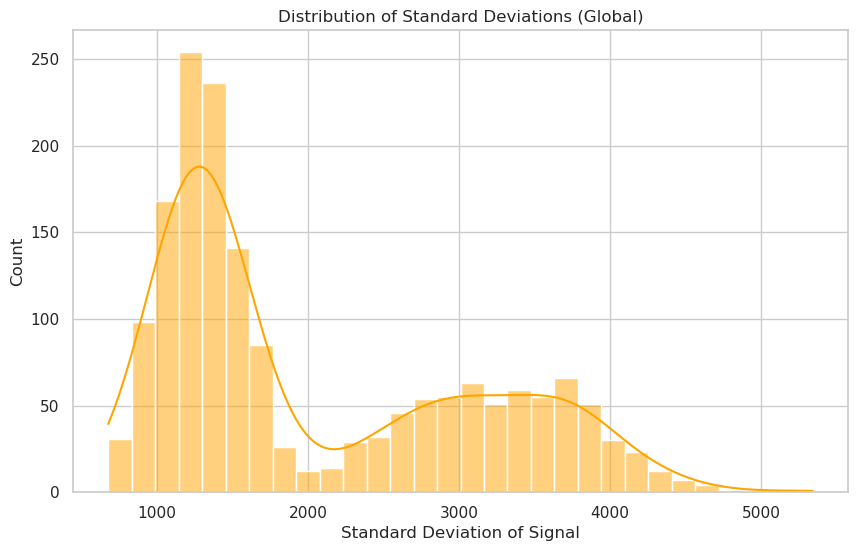

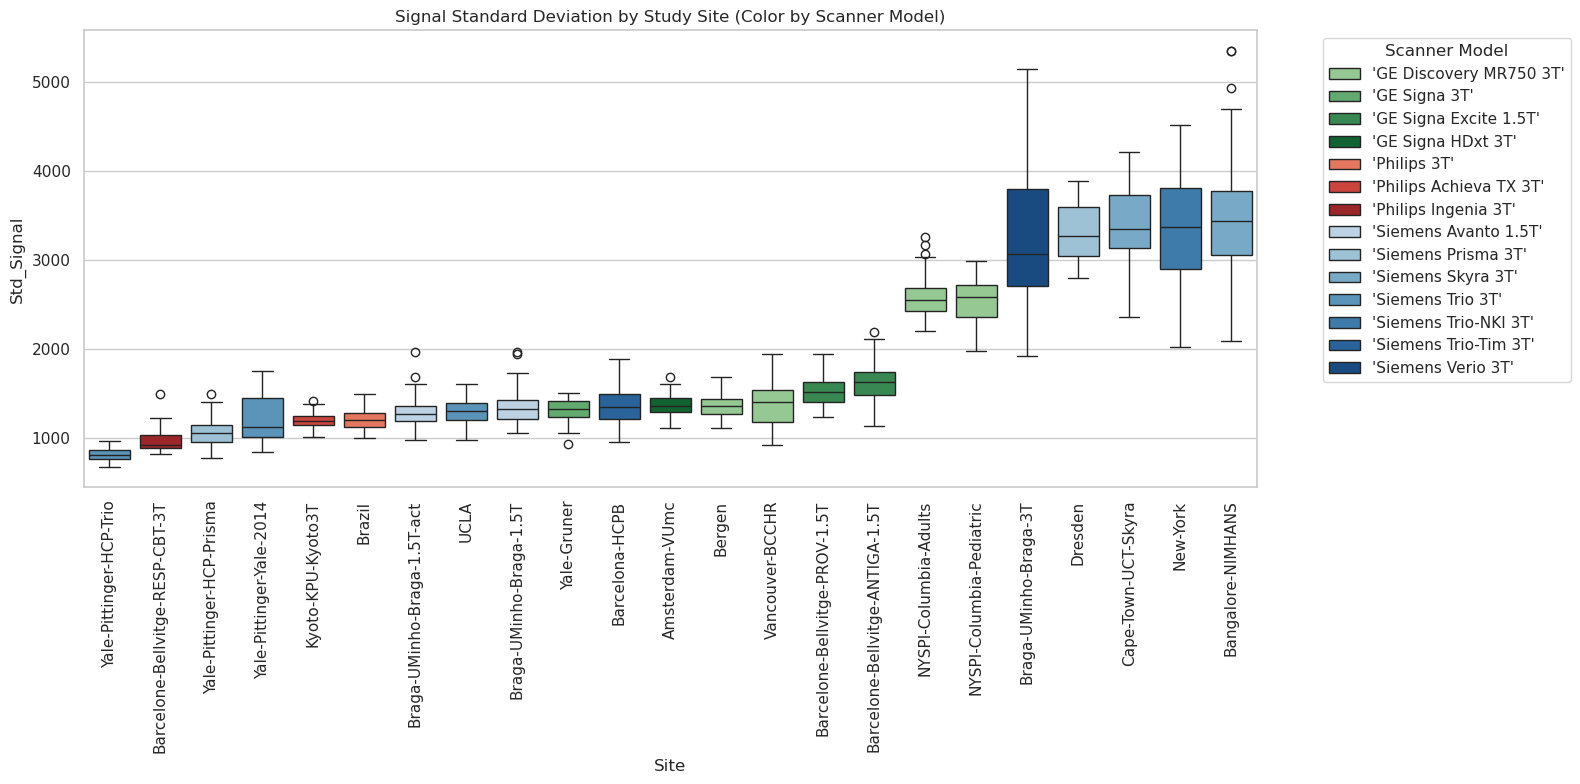

/tmp/ipykernel_2293218/2622055921.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Std_Signal', data=stats_df, palette="Set2")


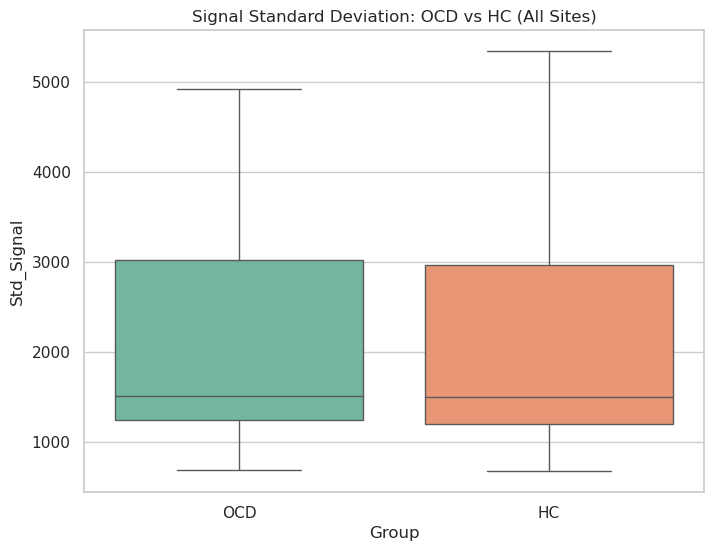

In [35]:
# 1) Global Distribution
plt.figure(figsize=(10, 6))
sns.histplot(stats_df['Std_Signal'], kde=True, bins=30, color='orange')
plt.title("Distribution of Standard Deviations (Global)")
plt.xlabel("Standard Deviation of Signal")
plt.show()

# 2) Across Study Sites (Color by Scanner Model)
plt.figure(figsize=(16, 8))
# Sort sites by increasing median Std Signal
site_order_std = stats_df.groupby('Site')['Std_Signal'].median().sort_values().index.tolist()
sns.boxplot(x='Site', y='Std_Signal', hue='ScannerModel', data=stats_df, order=site_order_std, hue_order=unique_models, dodge=False, palette=model_colors)
plt.xticks(rotation=90)
plt.title("Signal Standard Deviation by Study Site (Color by Scanner Model)")
plt.legend(title='Scanner Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3) OCD vs HC
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Std_Signal', data=stats_df, palette="Set2")
plt.title("Signal Standard Deviation: OCD vs HC (All Sites)")
plt.show()

## 4. Site x Group Interactions

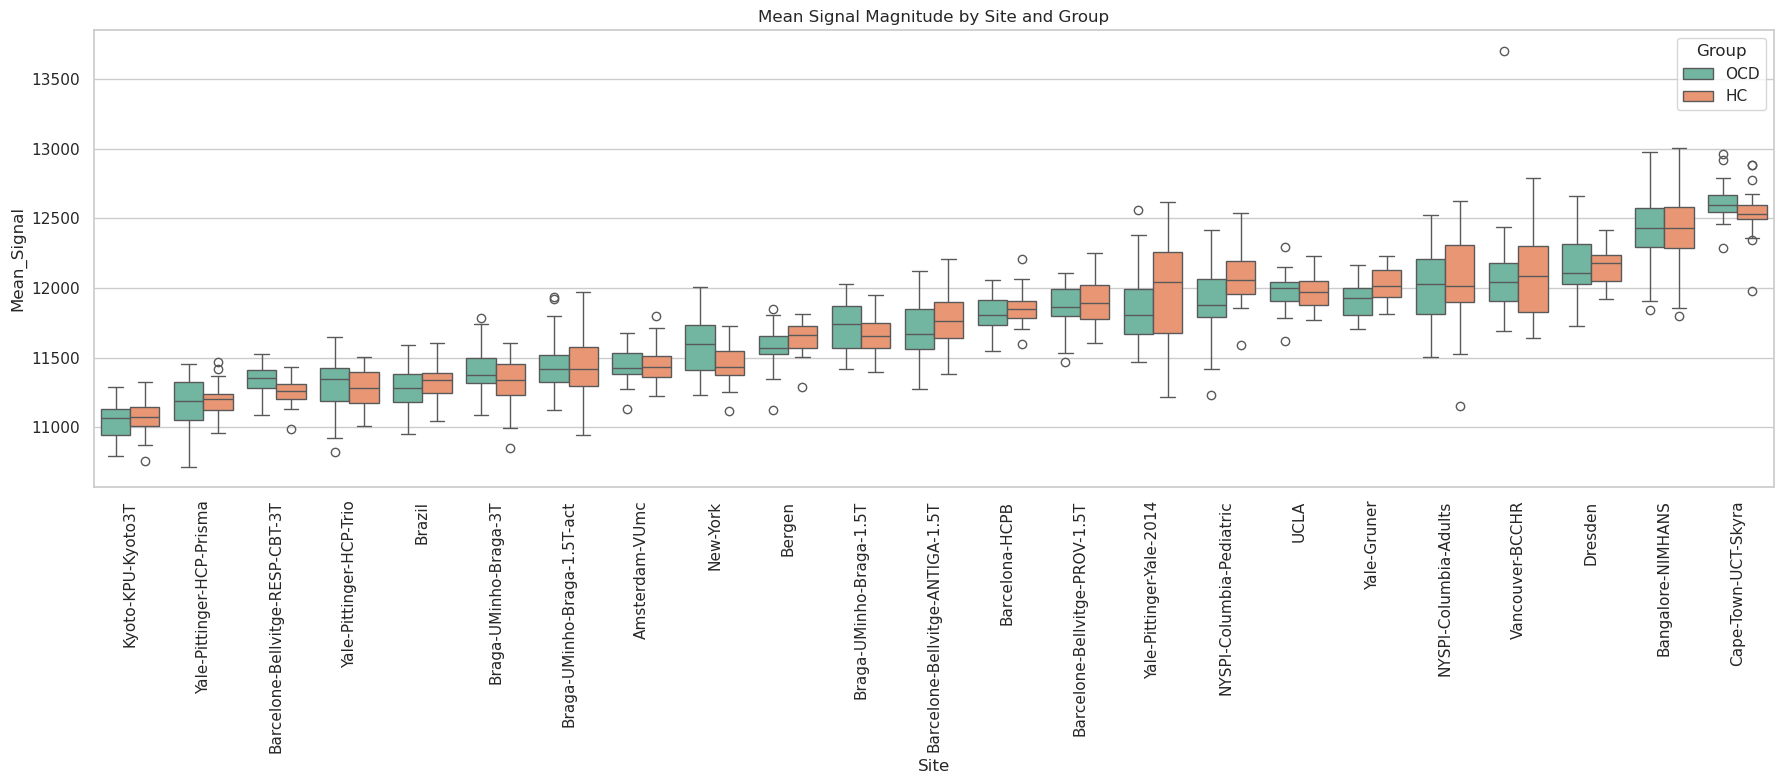

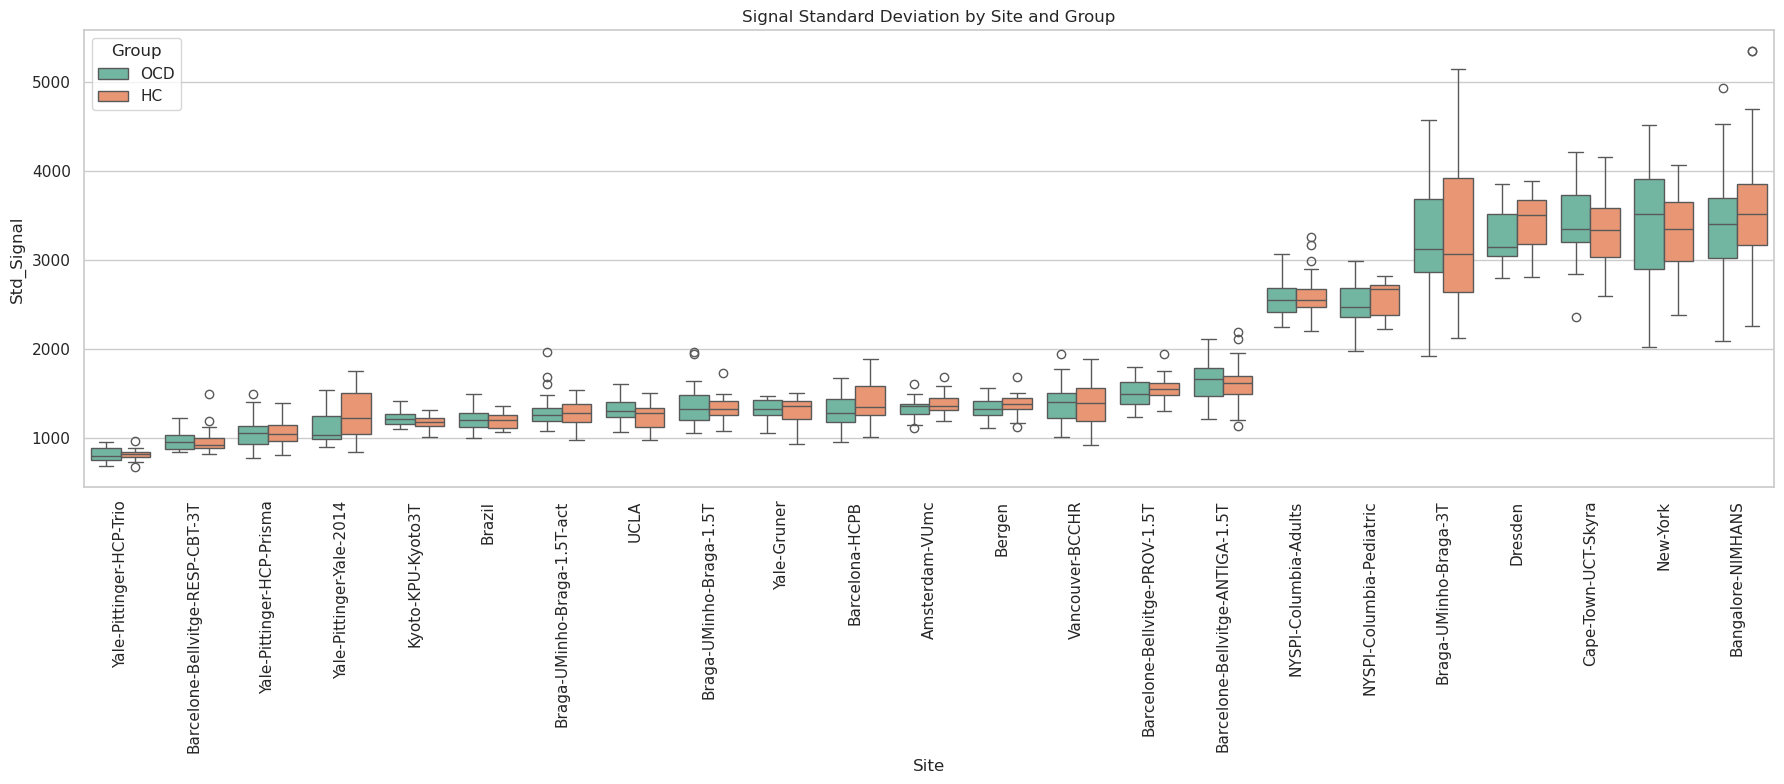

In [36]:
# Mean Signal by Site & Group
plt.figure(figsize=(18, 8))
sns.boxplot(x='Site', y='Mean_Signal', hue='Group', data=stats_df, order=site_order_mean, palette="Set2")
plt.xticks(rotation=90)
plt.title("Mean Signal Magnitude by Site and Group")
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# Std Signal by Site & Group
plt.figure(figsize=(18, 8))
sns.boxplot(x='Site', y='Std_Signal', hue='Group', data=stats_df, order=site_order_std, palette="Set2")
plt.xticks(rotation=90)
plt.title("Signal Standard Deviation by Site and Group")
plt.legend(title='Group')
plt.tight_layout()
plt.show()